In [12]:
from imports import  *

from sklearn.cluster import KMeans
from sklearn.feature_extraction.image import extract_patches_2d

In [13]:
def read_data_from_pickles(X_path="my_saved_files/X_train.npy", 
                           Y_path="my_saved_files/Y_train.npy", 
                           train_ids_path="my_saved_files/train_ids_ser.p"):
    
    
    X_train = np.load(X_path)
    Y_train = np.load(Y_path)
    train_ids_ser = pd.read_pickle(train_ids_path)
    
    X_test = np.load("my_saved_files/X_test.npy")
    test_ids_ser = pd.read_pickle("my_saved_files/test_ids_ser.p")

    print(X_train.shape, Y_train.shape, train_ids_ser.shape)
    
    return X_train, Y_train, train_ids_ser, X_test, test_ids_ser

In [14]:
X_train, Y_train, train_ids_ser, X_test, test_ids_ser = read_data_from_pickles(X_path="my_saved_files/X_train.npy", 
                           Y_path="my_saved_files/Y_train.npy", 
                           train_ids_path="my_saved_files/train_ids_ser.p")

(670, 128, 128, 3) (670, 128, 128, 1) (670,)


In [15]:
X = np.concatenate([X_train, X_test])
X.shape

(735, 128, 128, 3)

In [57]:
def plot_image(img):
    parms_dict = {}
    if len(img.shape)==4 and img.shape[0]==1:
        img = img.squeeze(axis=0)
    if len(img.shape)==3 and img.shape[-1]==1:
        img = img.squeeze(axis=-1)
        parms_dict["cmap"] = plt.get_cmap("gray")

    if img.max()>1:
        img = img/255.
    plt.imshow(img, **parms_dict)

def plot_img_mask_maskPred(img, msk, mskP=None, figsize=(16,8)):
    fig = plt.figure(figsize=figsize)
    
    plt.subplot(131)
    plot_image(img)
    plt.subplot(132)
    plot_image(msk)
    if mskP is not None:
        plt.subplot(133)
        plot_image(mskP)
    

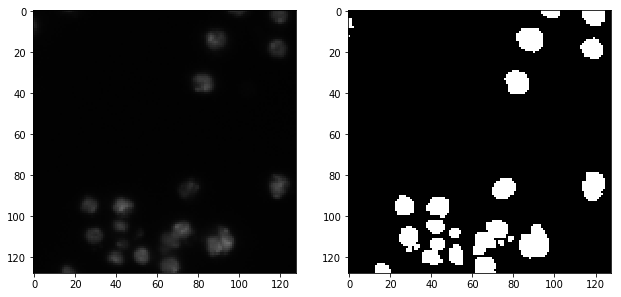

In [58]:
plot_img_mask_maskPred(X[0], Y_train[0])

In [59]:
x = X[0]

In [60]:
def three_channels_hist(x):
    bins = np.arange(0, 256, 10)
    a = np.histogram(x[0].flatten(), bins=bins)[0], np.histogram(x[1].flatten(), bins=bins)[0], np.histogram(x[2].flatten(), bins=bins)[0]
    return np.concatenate(a)

In [61]:
pics_hists = []
for x in X:
    pics_hists.append(three_channels_hist(x))
pics_hists = np.vstack(pics_hists)

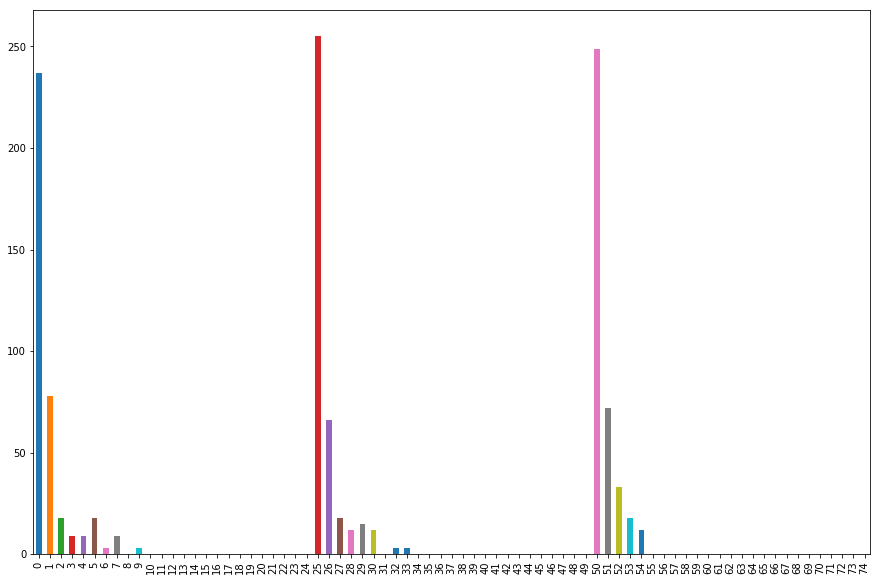

In [62]:
pd.Series(pics_hists[100]).plot("bar", figsize=(15, 10))

In [63]:
from sklearn.cluster import KMeans

In [74]:
def plot_n_over_n_grid_of_samples(X, n):
#     subfolders = np.random.choice(glob(path+"*"), n*n, replace=False)
    kmeans = KMeans(n_clusters=5, random_state=0).fit(pics_hists)
    preds = kmeans.predict(pics_hists[:25])

    plt.figure(figsize=(18, 18))
    gs1 = gridspec.GridSpec(n, n)
    gs1.update(wspace=0.001, hspace=0.001) # set the spacing between axes. 

    for i in range(1, n*n+1):
        img = X[i-1]
        plt.subplot(n, n, i)
        plt.axis('off')
        plt.title("%d ==> %d"%(i, preds[i-1]))
        plt.imshow(img)

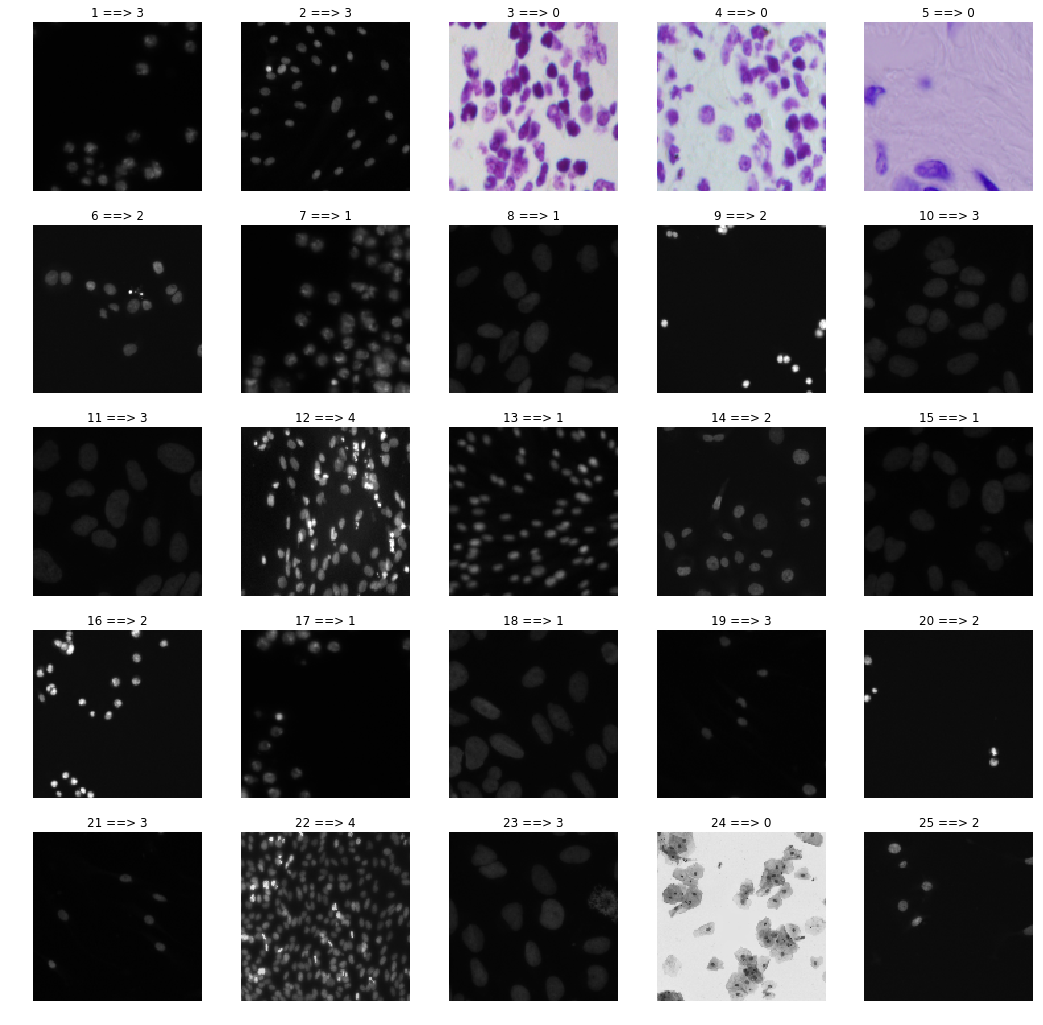

In [75]:
plot_n_over_n_grid_of_samples(X, 5)

### Bag of Semantic Words

In [126]:
def get_patches_from_single_image(img, patch_size, stride=None):
    if stride is None:
        stride=patch_size
    patches = extract_patches_2d(image=img, patch_size=(patch_size, patch_size))
    idx = []
    for j in range((img.shape[0]-patch_size)//stride + 1):
        idx += [j*stride*(img.shape[0] - patch_size + 1) + i*stride for i in range((img.shape[1]-patch_size)//stride + 1)]
#     [i*stride for i in range((img.shape[1]-patch_size)//stride + 1)]
#     print(len(idx), idx)
    return patches[idx]

In [127]:
def stack_patches_all_images(imgs, patch_size):
    all_patches = []
    for img in tqdm(imgs):
        all_patches.append(get_patches_from_single_image(img, patch_size))
    all_patches = np.concatenate(all_patches)
    
    return all_patches

In [128]:
def plot_patches_grid(patches, n):
    plt.subplots(n, n, figsize=(18, 18))
    for i, im in enumerate(patches):
        plt.subplot(n,n,i+1)
        plt.imshow(im)
        plt.title(i+1)
        plt.xticks([])
        plt.yticks([])

In [129]:
def flatten_patches(all_patches):
    return all_patches.reshape(all_patches.shape[0], -1)

In [130]:
def train_kmeans(features, n_clusters, random_state=0):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
    return kmeans

In [123]:
def remerge_patches(patches, n, x):
    r = []
    for i in range(n):
        r.append(np.concatenate(patches[i*n:(i+1)*n], axis=1))
    r = np.concatenate(r)

    plt.subplot("121")
    plt.imshow(x)
    plt.subplot("122")
    plt.imshow(r)

#### Step 1: Build "dictionary"

In [131]:
all_patches = stack_patches_all_images(X, 16)
all_patches.shape

100%|███████████████████████████████████████████████████████████████████████████████| 735/735 [00:04<00:00, 156.00it/s]


(47040, 16, 16, 3)

In [139]:
# remerge_patches(all_patches[:64], 8, X[0])
# # plot_patches_grid(patches=patches, n=8)

In [136]:
features = flatten_patches(all_patches=all_patches)
features.shape

(47040, 768)

In [138]:
kmeans = train_kmeans(features=features, n_clusters=200)

#### Cluster images 

In [148]:
def get_image_hist(img, patch_size, kmeans):
    patches = get_patches_from_single_image(img, patch_size)
    features = flatten_patches(patches)
    b = pd.Series(kmeans.predict(features)).value_counts()
    hist = pd.Series(200*[0], index=np.arange(200))
    hist[b.index] = b
    
    return hist

In [150]:
patch_size=16
hists = []
for img in tqdm(X):
    hists.append(get_image_hist(img, patch_size, kmeans))

100%|███████████████████████████████████████████████████████████████████████████████| 735/735 [00:06<00:00, 108.13it/s]


In [162]:
kmeans2 = KMeans(n_clusters=3, random_state=0).fit(hists)

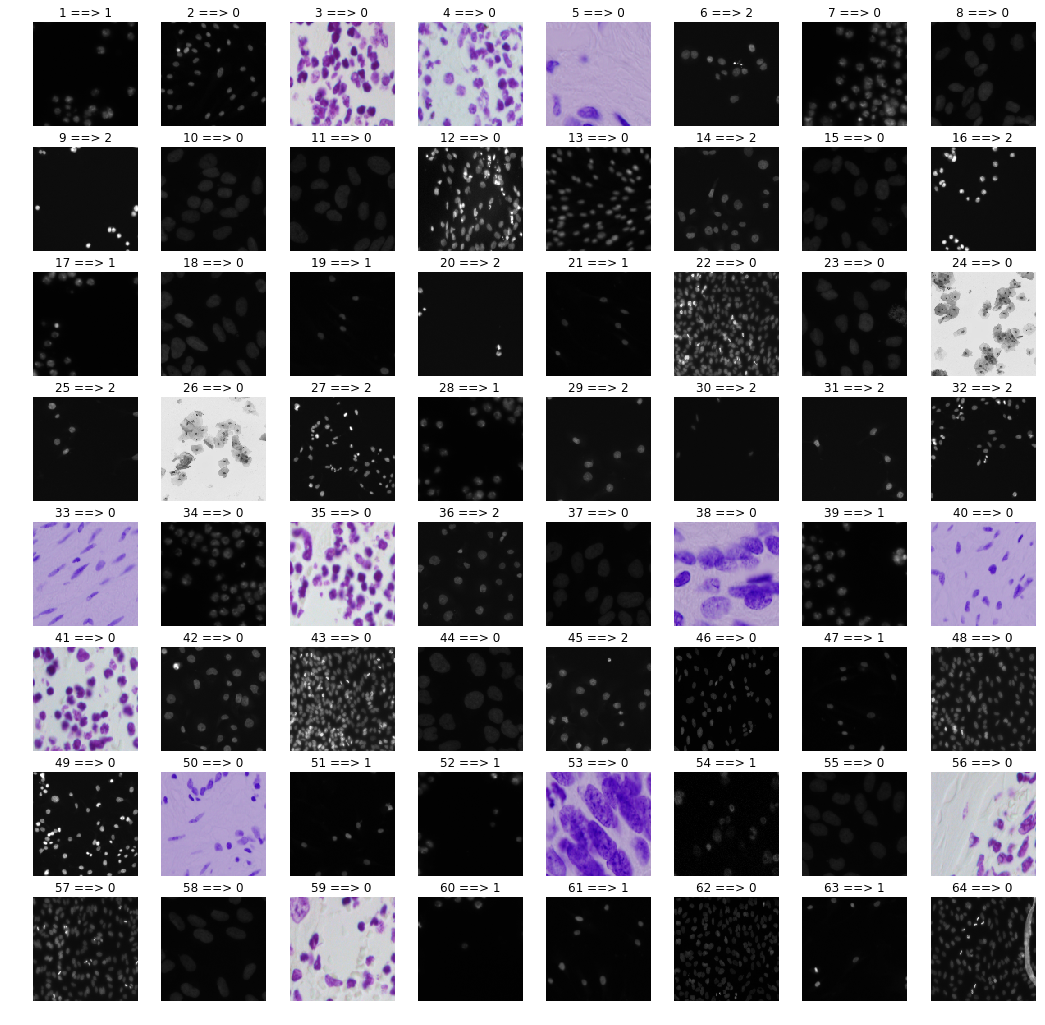

In [163]:
n = 8
preds = kmeans2.predict(hists)

plt.figure(figsize=(18, 18))
for i in range(1, n*n+1):
    img = X[i-1]
    plt.subplot(n, n, i)
    plt.axis('off')
    plt.title("%d ==> %d"%(i, preds[i-1]))
    plt.imshow(img)